 ![FREYA Logo](https://github.com/datacite/pidgraph-notebooks-python/blob/master/images/freya_200x121.png?raw=true) | [FREYA](https://www.project-freya.eu/en) WP2 [User Story3](https://www.pidforum.org/t/pid-graph-graphql-example-research-organization/929) | As an administrator for the University of Oxford I am interested in the reuse of research outputs from our university, so that I can help identify the most interesting research outputs.
:------------- | :------------- | :-------------

It is important for research organisations to measure quality and quantity of their outputs as well as their relevance to latest global research trends and to their own strategic science direction.<p />
This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to retrieve up to 100 outputs (e.g. publications or datasets) from [University of Oxford](https://ror.org/052gg0110) in order to quantify and visualise their reuse.

**Goal**: By the end of this notebook, for a given organization, you should be able to display:
- Counts of citations, views and downloads metrics, aggregated across all of the organization's outputs;
- An interactive stacked bar plot showing how the metric counts of each of the following <ins>output characteristics</ins> contributes the corresponding aggregated metric counts:<br><ins>Type</ins>, <ins>Publication Year</ins>, <ins>Author Affiliation</ins> and <ins>DOI</ins>, e.g. <br><br><img src="example_plot.png" width="353" height="206" />
- A word cloud of words from output titles in which word size is determined by the <ins>aggregated citations, views and downloads count</ins> corresponding to all output titles in which it appears
- An interactive force-directed graph of affiliations of organization's outputs' authors, in which:
 - Each node representats an author affiliation;
 - The width of each edge reflects the number of outputs that the two affiliation nodes it connects have in common; 
 - The colour of each node reflects the number of affiliations of co-authors across all the outputs - the more co-author affiliations, the closer to red the colour becomes., e.g. <br><br><img src="example_plot1.png" width="370" height="320" />

## Install libraries and prepare GraphQL client

In [1]:
%%capture
# Install required Python packages
!pip install gql requests numpy plotly pyvis

In [2]:
# Prepare the GraphQL client
import requests
from IPython.display import display, Markdown
from gql import gql, Client
from gql.transport.requests import RequestsHTTPTransport

_transport = RequestsHTTPTransport(
    url='https://api.datacite.org/graphql',
    use_json=True,
)

client = Client(
    transport=_transport,
    fetch_schema_from_transport=True,
)

## Define and run GraphQL query
Define the GraphQL query to retrieve up to 100 outputs (e.g. publications or datasets) from [University of Oxford](https://ror.org/052gg0110).

In [3]:
# Generate the GraphQL query to retrieve up to 100 outputs of University of Oxford, with at least 100 views each.
query_params = {
    "rorId" : "https://ror.org/052gg0110",
    "maxOutputs": 100,
    "minViews" : 100
}

query = gql("""query getOutputs($rorId: ID!, $maxOutputs: Int!, $minViews: Int!)
{
 organization(id: $rorId) {
    id
    name
    alternateName
    citationCount
    viewCount
    downloadCount
    works(hasViews: $minViews, first: $maxOutputs) {
      totalCount
      published {
        title
        count
      }
      resourceTypes {
        title
        count
      }
      nodes {
        id
        type
        publisher
        publicationYear
        titles {
          title
        }
        citations {
           nodes {
             id
             titles {
                title
             }
           }
        }
        creators {
          id
          name
          affiliation {
            id
            name
          }
        }
        citationCount
        viewCount
        downloadCount
      }
    }
  }
}
""")

Run the above query via the GraphQL client

In [4]:
import json
data = client.execute(query, variable_values=json.dumps(query_params))

## Display total metric counts 
Display total number of <ins>citations, views and downloads</ins> of [University of Oxford](https://ror.org/052gg0110)'s outputs.

In [7]:
# Get the total count per metric, aggregated across all of the organization's outputs
organization = data['organization']
organizationName = organization['name']
# Initialise metric counts across all outputs of the organization
metricCounts = {}
for metric in ['citationCount', 'viewCount', 'downloadCount']:
    metricCounts[metric] = 0
    
# Aggregate metric counts across all the parts
for node in organization['works']['nodes']:
    for metric in metricCounts:
         metricCounts[metric] += node[metric]
            
# Display the aggregated metric counts
tableBody=""
for metric in metricCounts:        
    tableBody += "%s | **%s**\n" % (metric, str(metricCounts[metric]))
if tableBody:
   display(Markdown("Aggregated metric counts across %d outputs of [University of Oxford](https://ror.org/052gg0110):" % organization['works']['totalCount']))
   display(Markdown("|Metric | Aggregated Count|\n|---|---|\n%s" % tableBody))                                 

Aggregated metric counts across 74 outputs of [University of Oxford](https://ror.org/052gg0110):

|Metric | Aggregated Count|
|---|---|
citationCount | **5**
viewCount | **16056**
downloadCount | **6357**


## Plot metric counts per output type
Plot stacked bar plot showing how <ins>each type</ins> of [University of Oxford](https://ror.org/052gg0110)'s outputs contribute their metric counts to the corresponding aggregated total.

In [8]:
import plotly.io as pio
import plotly.express as px
from IPython.display import IFrame
import pandas as pd

# Adapted from: https://stackoverflow.com/questions/58766305/is-there-any-way-to-implement-stacked-or-grouped-bar-charts-in-plotly-express
def px_stacked_bar(df, color_name='Metric', y_name='Metrics', **pxargs):
    idx_col = df.index.name
    m = pd.melt(df.reset_index(), id_vars=idx_col, var_name=color_name, value_name=y_name)
    # For Plotly colour sequences see: https://plotly.com/python/discrete-color/     
    return px.bar(m, x=idx_col, y=y_name, color=color_name, **pxargs, 
                  color_discrete_sequence=px.colors.qualitative.Pastel1)

# Collect metric counts
organization = data['organization']

# Initialise dicts for the stacked bar plot
labels = {0: 'All Output Types'}
citationCounts = {}
viewCounts = {}
downloadCounts = {}

# Collect output type labels
outputTypesSet = set([])
outputType2Pos = {}
for node in organization['works']['nodes']:
    outputTypesSet.add(node['type'])
outputTypes = list(outputTypesSet);    
for pos, outputType in enumerate(outputTypes):
    labels[pos + 1] = outputType
    outputType2Pos[outputType] = pos + 1
    
# Initialise metric counts
for pos, _ in enumerate(labels):
    citationCounts[pos] = 0
    viewCounts[pos] = 0
    downloadCounts[pos] = 0
# Populate metric counts per output type (key = i) and add them to the aggregated counts (key: 0)
for node in organization['works']['nodes']:
    pos = outputType2Pos[node['type']]
    citationCounts[0] += node['citationCount']
    viewCounts[0] += node['viewCount']
    downloadCounts[0] += node['downloadCount']
    citationCounts[pos] += node['citationCount']
    viewCounts[pos] += node['viewCount']
    downloadCounts[pos] += node['downloadCount']

# Create stacked bar plot
x_name = "%s's Output Types" % organizationName
df = pd.DataFrame({x_name: labels,
                   'Citations': citationCounts,
                   'Views': viewCounts,
                   'Downloads': downloadCounts})
fig = px_stacked_bar(df.set_index(x_name), y_name = "Counts")

# Set plot background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

# Write interactive plot out to html file
pio.write_html(fig, file='ot_out.html')

# Display plot from the saved html file
display(Markdown("Citations, views and downloads for [University of Oxford](https://ror.org/052gg0110)'s outputs, shown per output type as stacked bar plot:"))
IFrame(src="./ot_out.html", width=500, height=500)

Citations, views and downloads for [University of Oxford](https://ror.org/052gg0110)'s outputs, shown per output type as stacked bar plot:

## Plot metric counts per year
Plot stacked bar plot showing how outputs of [University of Oxford](https://ror.org/052gg0110) in each year contribute their metric counts to the corresponding aggregated total.

In [9]:
import plotly.io as pio
import plotly.express as px
from IPython.display import IFrame
import pandas as pd

# Adapted from: https://stackoverflow.com/questions/58766305/is-there-any-way-to-implement-stacked-or-grouped-bar-charts-in-plotly-express
def px_stacked_bar(df, color_name='Metric', y_name='Metrics', **pxargs):
    idx_col = df.index.name
    m = pd.melt(df.reset_index(), id_vars=idx_col, var_name=color_name, value_name=y_name)
    # For Plotly colour sequences see: https://plotly.com/python/discrete-color/     
    return px.bar(m, x=idx_col, y=y_name, color=color_name, **pxargs, 
                  color_discrete_sequence=px.colors.qualitative.Pastel1)

# Collect metric counts
organization = data['organization']

# Initialise dicts for the stacked bar plot
labels = {}
citationCounts = {}
viewCounts = {}
downloadCounts = {}

# Collect output type labels
outputPubYearsSet = set([])
outputPubYear2Pos = {}
for node in organization['works']['nodes']:
    if node['publicationYear'] != '':
        outputPubYearsSet.add(node['publicationYear'])
outputPubYears = list(outputPubYearsSet);    
for pos, outputPubYear in enumerate(outputPubYears):
    labels[pos] = outputPubYear
    outputPubYear2Pos[outputPubYear] = pos
    
# Initialise metric counts
for pos, _ in enumerate(labels):
    citationCounts[pos] = 0
    viewCounts[pos] = 0
    downloadCounts[pos] = 0
# Populate metric counts per output type (key = i) and add them to the aggregated counts (key: 0)
for node in organization['works']['nodes']:
    pos = outputPubYear2Pos[node['publicationYear']]
    citationCounts[pos] += node['citationCount']
    viewCounts[pos] += node['viewCount']
    downloadCounts[pos] += node['downloadCount']

# Create stacked bar plot
x_name = "Publication Years of %s's Outputs" % organizationName
df = pd.DataFrame({x_name: labels,
                   'Citations': citationCounts,
                   'Views': viewCounts,
                   'Downloads': downloadCounts})
fig = px_stacked_bar(df.set_index(x_name), y_name = "Counts")

# Set plot background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

# Write interactive plot out to html file
pio.write_html(fig, file='yr_out.html')

# Display plot from the saved html file
display(Markdown("Citations, views and downloads counts of [University of Oxford](https://ror.org/052gg0110)'s outputs, shown per publication year as stacked bar plot:"))
IFrame(src="./yr_out.html", width=1000, height=500)

Citations, views and downloads counts of [University of Oxford](https://ror.org/052gg0110)'s outputs, shown per publication year as stacked bar plot:

## Plot metric counts per author affiliation
Plot stacked bar plot showing how individual author's affiliations of [University of Oxford](https://ror.org/052gg0110)'s outputs contribute their metric counts to the corresponding aggregated total. The plot shows <ins>top 30</ins> author affiliations (other than University of Oxford) by the <ins>combined citations, views and downloads count<ins>.

In [10]:
import plotly.io as pio
import plotly.express as px
from IPython.display import IFrame
import pandas as pd
from operator import itemgetter

# Adapted from: https://stackoverflow.com/questions/58766305/is-there-any-way-to-implement-stacked-or-grouped-bar-charts-in-plotly-express
# c.f. https://plotly.com/python-api-reference/generated/plotly.express.bar.html#plotly.express.bar
def px_stacked_bar(df, color_name='Metric', y_name='Metrics', **pxargs):
    idx_col = df.index.name
    m = pd.melt(df.reset_index(), id_vars=idx_col, var_name=color_name, value_name=y_name)
    # For Plotly colour sequences see: https://plotly.com/python/discrete-color/     
    return px.bar(m, x=idx_col, y=y_name, color=color_name, **pxargs, 
                  color_discrete_sequence=px.colors.qualitative.Pastel1)

MAX_TOP_AFFILIATIONS_BY_ALL_METRIC_COUNT=30

# Collect metric counts
organization = data['organization']
organizationName = organization['name']

# Initialise dicts for the stacked bar plot
labels = {}
citationCounts = {}
viewCounts = {}
downloadCounts = {}

# Collect output type labels
affiliationsSet = set([])
for node in organization['works']['nodes']:
    for creator in node['creators']:
        for affiliation in creator['affiliation']:
            affiliationsSet.add(affiliation['name'])
affiliations = list(affiliationsSet);    
    
# Retrieve metric counts by affiliation
affiliation2CitationCount = {}
affiliation2ViewCount = {}
affiliation2DownloadCount = {}
affiliation2AllMetricCount = {}
# Initialise metric counts
for an in affiliations:
    affiliation2CitationCount[an] = 0
    affiliation2ViewCount[an] = 0
    affiliation2DownloadCount[an] = 0
    affiliation2AllMetricCount[an] = 0
    
for node in organization['works']['nodes']:
    seenAffiliationInNode = set([])
    for creator in node['creators']:  
        for affiliation in creator['affiliation']:
            an = affiliation['name']
            if an not in seenAffiliationInNode: 
                affiliation2CitationCount[an] += node['citationCount']
                affiliation2ViewCount[an] += node['viewCount']
                affiliation2DownloadCount[an] += node['downloadCount']
                affiliation2AllMetricCount[an] += node['citationCount'] + node['viewCount'] + node['downloadCount']
                seenAffiliationInNode.add(an)         
# Initialise metric counts
for pos in range(len(affiliations)):
    citationCounts[pos] = 0
    viewCounts[pos] = 0
    downloadCounts[pos] = 0
    
# Populate metric counts per output type (key = pos)
pos = 0
for an, _ in sorted(affiliation2AllMetricCount.items(), key = itemgetter(1), reverse = True):
    if an != organizationName:
        labels[pos] = an
        citationCounts[pos] += affiliation2CitationCount[an]
        viewCounts[pos] += affiliation2ViewCount[an]
        downloadCounts[pos] += affiliation2AllMetricCount[an]
        pos += 1
    if pos >= MAX_TOP_AFFILIATIONS_BY_ALL_METRIC_COUNT:
        break;

# Create stacked bar plot
x_name = "Affiliations of %s's Output Authors" % organizationName
df = pd.DataFrame({x_name: labels,
                   'Citations': citationCounts,
                   'Views': viewCounts,
                   'Downloads': downloadCounts})
fig = px_stacked_bar(df.set_index(x_name), y_name = "Counts")

# Set plot background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

# Write interactive plot out to html file
pio.write_html(fig, file='af_out.html')

# Display plot from the saved html file
display(Markdown("Citations, views and downloads counts across affiliations of authors of [University of Oxford](https://ror.org/052gg0110)'s outputs, shown as stacked bar plot.<br>The plot shows <ins>top 30</ins> author affiliations (other than University of Oxford) by the <ins>combined citations, views and downloads count<ins>."))
IFrame(src="./af_out.html", width=1000, height=800)

Citations, views and downloads counts across affiliations of authors of [University of Oxford](https://ror.org/052gg0110)'s outputs, shown as stacked bar plot.<br>The plot shows <ins>top 30</ins> author affiliations (other than University of Oxford) by the <ins>combined citations, views and downloads count<ins>.

## Plot metric counts per individual output
Plot stacked bar plot showing how individual outputs of [University of Oxford](https://ror.org/052gg0110)'s contribute their metric counts to the corresponding aggregated total. The plot shows DOIs of <ins>top 30</ins> outputs by the <ins>combined citations, views and downloads count<ins>.

In [11]:
import plotly.io as pio
import plotly.express as px
from IPython.display import IFrame
import pandas as pd
from operator import itemgetter

# Adapted from: https://stackoverflow.com/questions/58766305/is-there-any-way-to-implement-stacked-or-grouped-bar-charts-in-plotly-express
# c.f. https://plotly.com/python-api-reference/generated/plotly.express.bar.html#plotly.express.bar
def px_stacked_bar(df, color_name='Metric', y_name='Metrics', **pxargs):
    idx_col = df.index.name
    m = pd.melt(df.reset_index(), id_vars=idx_col, var_name=color_name, value_name=y_name)
    # For Plotly colour sequences see: https://plotly.com/python/discrete-color/     
    return px.bar(m, x=idx_col, y=y_name, color=color_name, **pxargs, 
                  color_discrete_sequence=px.colors.qualitative.Pastel1)

MAX_TOP_DOIS_BY_ALL_METRIC_COUNT=30

# Collect metric counts
organization = data['organization']
organizationName = organization['name']

# Initialise dicts for the stacked bar plot
labels = {}
citationCounts = {}
viewCounts = {}
downloadCounts = {}
    
# Retrieve metric counts by doi
doi2CitationCount = {}
doi2ViewCount = {}
doi2DownloadCount = {}
doi2AllMetricCount = {}

for node in organization['works']['nodes']:
    doi = node['id']
    doi2CitationCount[doi] = node['citationCount']
    doi2ViewCount[doi] = node['viewCount']
    doi2DownloadCount[doi] = node['downloadCount']
    doi2AllMetricCount[doi] = node['citationCount'] + node['viewCount'] + node['downloadCount']  
    
# Initialise metric counts
pos = 0;
for node in organization['works']['nodes']:
    citationCounts[pos] = 0
    viewCounts[pos] = 0
    downloadCounts[pos] = 0
    pos += 1
    
# Populate metric counts per output type (key = pos)
pos = 0
for doi, _ in sorted(doi2AllMetricCount.items(), key = itemgetter(1), reverse = True):
    labels[pos] = "<a href=\"%s\">%s</a>" % (doi, "/".join(doi.split("/")[3:]))
    citationCounts[pos] += doi2CitationCount[doi]
    viewCounts[pos] += doi2ViewCount[doi]
    downloadCounts[pos] += doi2AllMetricCount[doi]
    pos += 1
    if pos >= MAX_TOP_DOIS_BY_ALL_METRIC_COUNT:
        break;

# Create stacked bar plot
x_name = "%s's Output DOIs" % organizationName
df = pd.DataFrame({x_name: labels,
                   'Citations': citationCounts,
                   'Views': viewCounts,
                   'Downloads': downloadCounts})
fig = px_stacked_bar(df.set_index(x_name), y_name = "Counts")

# Set plot background to transparent
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
})

# Write interactive plot out to html file
pio.write_html(fig, file='doi_out.html')

# Display plot from the saved html file
display(Markdown("Citations, views and downloads counts for individual outputs of [University of Oxford](https://ror.org/052gg0110), shown as stacked bar plot.<br>The plot shows DOIs of <ins>top 30</ins> outputs by the <ins>combined citations, views and downloads count<ins>."))
IFrame(src="./doi_out.html", width=1000, height=800)

Citations, views and downloads counts for individual outputs of [University of Oxford](https://ror.org/052gg0110), shown as stacked bar plot.<br>The plot shows DOIs of <ins>top 30</ins> outputs by the <ins>combined citations, views and downloads count<ins>.

## Display a word cloud of output titles.
Display a word cloud of words from output titles in which word size is determined by the <ins>aggregated citations, views and downloads count</ins> corresponding to all output titles in which it appears.

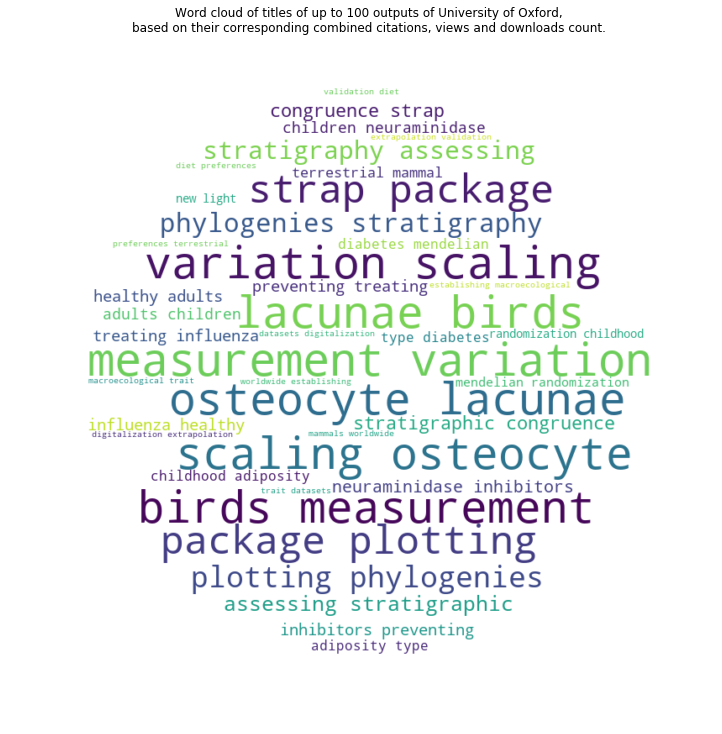

In [13]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import re

stopWords = set(STOPWORDS)
stopWords.update(['_','data','from','of','in','case','study'])

organization = data['organization']
organizationName = organization['name']

titleWords=[]
for metricCount in ['citationCount', 'viewCount', 'downloadCount']:
    for node in organization['works']['nodes']:
        for title in node['titles']:
            tokens = [t.lower() for t in re.split(' |:', str(title['title'])) if t.lower() not in stopWords] 
            for i in range(node[metricCount]):
                titleWords += tokens
     
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 345 ** 2
mask = 255 * mask.astype(int)
    
wordcloud = WordCloud(width = 600, height = 600, 
                background_color ='white', 
                stopwords = stopWords, 
                min_font_size = 10, 
                prefer_horizontal = 0.95,
                mask = mask).generate(" ".join(titleWords))
    
fig, ax = plt.subplots(1, 1, figsize = (10, 10), facecolor = None)
ax.set_title("Word cloud of titles of up to %d outputs of %s,\nbased on their corresponding combined citations, views and downloads count." % (query_params['maxOutputs'], organizationName))
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

## Plot an interactive force-directed graph of output authors' affiliations
Plot a force-directed graph of [University of Oxford](https://ror.org/052gg0110)'s outputs author affiliations, in which:
- Each node representats an author affiliation. 
- The width of each edge reflects the number of outputs that the two affiliation nodes it connects have in common. 
- The colour of each node reflects the number of affiliations of co-authors across all the outputs - the more co-author affiliations, the closer to red the colour becomes.

In [15]:
from pyvis.network import Network
import pandas as pd

# Colour swatch for the network nodes
colours = ["#00ffff", "#8000ff", "#bf00ff", "#ff00ff", "#ff00bf", "#ff0080", "#ff0040", "#ff0000"]

got_net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")
got_net.options.edges.inherit_colors(False)

# set the physics layout of the network
got_net.barnes_hut()

# ------------------------------
# Initialise intermediate data structure to store: (srcAf, trgAf) -> number of shared publications 
srcAfTrgAf2Count = {}
# Initialise intermediate data structure to store: af --> Set of connected affs
# Note that the number of connected affs will determine the colour of each affiliation node
af2OtherAfs = {}
organization = data['organization']
organizationName = organization['name']

# Populate srcAfTrgAf2Count
allAffs = set()
for node in organization['works']['nodes']:
    affSet = set()
    for creator in node['creators']:
        for affiliation in creator['affiliation']:
            af = affiliation['name']
            affSet.add(af)
    affs = sorted(list(affSet))
    allAffs.update(affs)
    for af in affs:
        for af1 in affs:
            if af1 != af:
                if af < af1:
                    tuple = (af, af1)
                else: 
                    tuple = (af1, af)
                if af not in af2OtherAfs:
                    af2OtherAfs[af] = set()
                af2OtherAfs[af].add(af1)
                if af1 not in af2OtherAfs:
                    af2OtherAfs[af1] = set()
                af2OtherAfs[af1].add(af)   
                
                if tuple not in srcAfTrgAf2Count:
                    srcAfTrgAf2Count[tuple] = 0
                else:
                    srcAfTrgAf2Count[tuple] += 1                   

# Populate data structures needed for the graph
sources, targets, weights = [], [], []
for tuple in srcAfTrgAf2Count:
    if srcAfTrgAf2Count[tuple] > 0:
        sources.append(tuple[0])
        targets.append(tuple[1])
        weights.append(srcAfTrgAf2Count[tuple])

edge_data = zip(sources, targets, weights)

# Parameters to help determine affiliation node colours - the more affiliations connected via authorship of outputs, the closer to red the colour
max_len = len(allAffs)
num_colours = len(colours)
div = max_len/num_colours/3

for e in edge_data:
    src = e[0]
    dst = e[1]
    w = e[2]
    colour_index = min(int(len(af2OtherAfs[src])/div), num_colours - 1)
    got_net.add_node(src, src, title=src, color = colours[colour_index])   
    colour_index = min(int(len(af2OtherAfs[dst])/div), num_colours - 1)
    got_net.add_node(dst, dst, title=dst, color = colours[colour_index])
    got_net.add_edge(src, dst, value=w)

neighbor_map = got_net.get_adj_list()

# add neighbor data to node hover data
for node in got_net.nodes:
    node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
    node["value"] = len(neighbor_map[node["id"]])

got_net.show("af_ng.html")
display(Markdown("N.B. Click on the plot, then use down/up mouse scroll to zoom in/out respectively.<br>When zoomed in, you will notice the affiliation label against each node.<br>Click on a node to see the list of 'neighbour' affiliations."))
IFrame(src="./af_ng.html", width=1000, height=800)

N.B. Click on the plot, then use down/up mouse scroll to zoom in/out respectively.<br>When zoomed in, you will notice the affiliation label against each node.<br>Click on a node to see the list of 'neighbour' affiliations.